In [2]:
import gymnasium as gym
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

env = gym.make('MountainCar-v0')

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend() # checks if one is running IPhyton environment like jupyter notebook
if is_ipython:
    from IPython import display

plt.ion() # interactive mode on, allows automatic plots when data is updated (whithout calling plt.show every time)

# if GPU is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayBuffer(object):

    def __init__(self, capacity):
        self.buffer = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.buffer.append(Transition(*args))   # need *args because Transition expects values when instantiated

    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)

    def __len__(self):
        return len(self.buffer)

In [4]:
class DQN(nn.Module):

    def __init__(self, n_observations, n_actions, n_nodes_per_layer=64, n_layers=2):
        super(DQN, self).__init__()
        self.layers = nn.ModuleList([nn.Linear(n_observations, n_nodes_per_layer)])
        for _ in range(n_layers - 1):
            self.layers.append(nn.Linear(n_nodes_per_layer, n_nodes_per_layer))
        self.output_layer = nn.Linear(n_nodes_per_layer, n_actions)

    def forward(self, x):
        for layer in self.layers:
            x = F.relu(layer(x))
        return self.output_layer(x)

In [5]:
BATCH_SIZE = 128 # BATCH_SIZE is the number of transitions sampled from the replay buffer
GAMMA = 0.99 # GAMMA is the discount factor as mentioned in the previous section
EPS_START = 0.9 # EPS_START is the starting value of epsilon
EPS_END = 0.05 # EPS_END is the final value of epsilon
EPS_DECAY = 1000 # EPS_DECAY controls the rate of exponential decay of epsilon, higher means a slower decay
TAU = 0.005 # TAU is the update rate of the target network
LR = 1e-4 # LR is the learning rate of the ``AdamW`` optimizer

# Get number of actions from gym action space
n_actions = env.action_space.n
# Get the number of state observations
state, info = env.reset()
n_observations = len(state)
#n_nodes_per_layer=80   BY DEFAULT 64
#n_layers=4         BY DEFAULT 2

policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())  ### ???

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)  # why optimizer only on policy_net.parameters? does that mean we dont update target net parameters?
buffer = ReplayBuffer(10000)


steps_done = 0


def select_action(state):
    global steps_done   #global variable: any changes made to steps_done within the function select_action will affect the variable defined outside the function's scope
    rand_num = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if rand_num > eps_threshold:
        with torch.no_grad():
            # t.max(1) finds max value along second dimension (action space)
            # .indices returns index of max values
            # .view() reshapes index into desired format
            return policy_net(state).max(1).indices.view(1, 1)      # select action with maximum expected reward 
    else:
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)
                # choose random action sampling from environment's action space with env.action_space.sample(), then transform into pytorch tensor

episode_durations = []


def plot_durations(show_result=False):
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1) #calculates the 100-episode moving averages of the durations
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

In [21]:
state, info = env.reset()
n_observations = len(state)
print(n_observations)
print(state)

2
[-0.44144994  0.        ]


In [6]:
def update():
    if len(buffer) < BATCH_SIZE:
        return # returns nothing, if buffer smaller than batch size, i.e. model is not optimized!
    
    transitions = buffer.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays. 
    batch = Transition(*zip(*transitions)) # i.e. zip(*[('a', 1), ('b', 2), ('c', 3), ('d', 4)]) = [('a', 'b', 'c', 'd'), (1, 2, 3, 4)]

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool) #checks each next_state in the minibatch (batch.next_state) and evaluates whether it is not "None"., if not "none" then episode not terminate, i.e. no final state. response = boolean (true, false)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None]) #iterates through each next_state in the minibatch, and if the next_state is not "None" (i.e. non final), it adds it to the list comprehension
    state_batch = torch.cat(batch.state) #concatenates the states from the minibatch (batch.state) into a single tensor (state_batch)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch) # Each row of the output corresponds to the Q-values for one state of the batch..gather(1, action_batch) selects elements from each row of the Q-values tensor according to the indices specified in action_batch. This operation effectively selects the Q-values for the actions that were taken in each state.
    
    # Compute Q(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1).values
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1).values   # the idea is that your policy_network learns some q values and gets updated each episode while target network only gets updated once in a while, where its parameters become closer to the policy network. Therefore the target network is slowly dragged towards the parameters of the policy network, which finally results in learning 
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

Complete


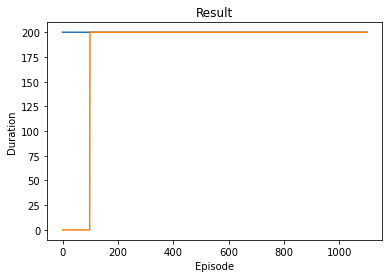

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [18]:
if torch.cuda.is_available():
    num_episodes = 6000
else:
    num_episodes = 1000

for i_episode in range(num_episodes):
    # Initialize the environment and get its state
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    for t in count():
        action = select_action(state)
        observation, reward, terminated, truncated, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        # Store the transition in memory
        buffer.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        update()

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)

        if done:
            episode_durations.append(t + 1)
            plot_durations()
            break

print('Complete')
plot_durations(show_result=True)
plt.ioff()
plt.show()

# no training until 100th episode because batch is too small